# Atividade 2 - Water Quality utilizando Knn
#### Aluno: Marcos Bezner Rampaso - 2149435

Esta atividade consiste em analisar os dados e classificar a água como potável ou não potável, o data frame utilizado será o *water_potability_nonans.csv*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score

In [ ]:
df = pd.read_csv("water_potability_nonans.csv")
df.head()

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0   8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
1   9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   
2   5.584087  188.313324  28748.687739     7.544869  326.678363    280.467916   
3  10.223862  248.071735  28749.716544     7.513408  393.663396    283.651634   
4   8.635849  203.361523  13672.091764     4.563009  303.309771    474.607645   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       18.436524       100.341674   4.628771           0  
1       11.558279        31.997993   4.075075           0  
2        8.399735        54.917862   2.559708           0  
3       13.789695        84.603556   2.672989           0  
4       12.363817        62.798309   4.401425           0

In [ ]:
print(df.dtypes)


ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object


# Analisando os dados

### Como primeiro passo, iremos analisar os dados para checar qual mostra-se mais promissor para a classificação. Para tal iremos gerar uma série de gráficos que nos mostram com detalhes os dados

Os gráficos serão gerados através de um algoritmo que automatiza os nomes com base em variáveis dos atributos, foi adicionado também um kde para ficar mais fácil a visualização

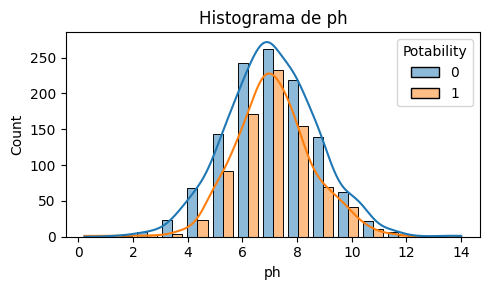

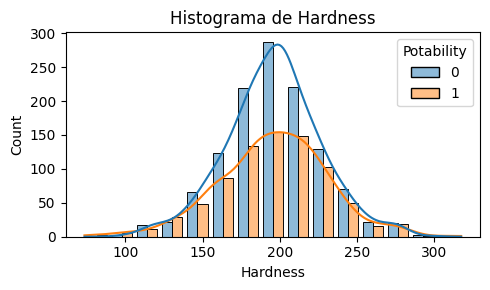

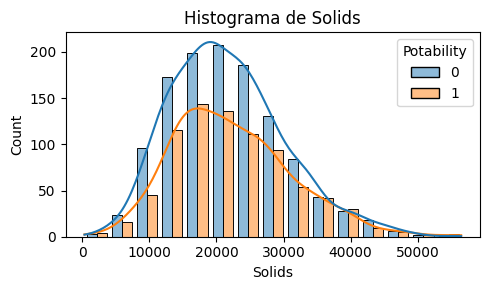

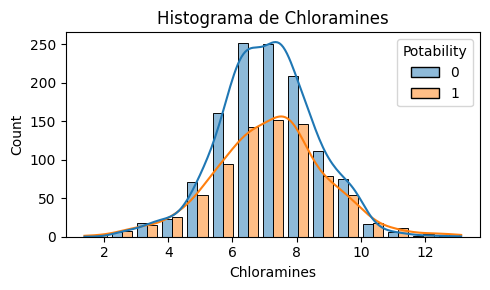

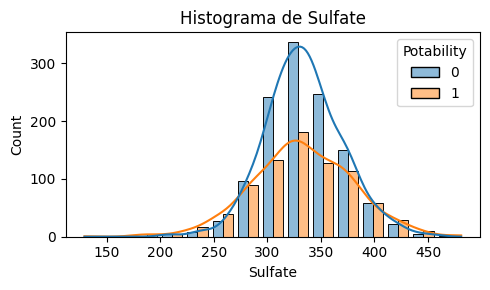

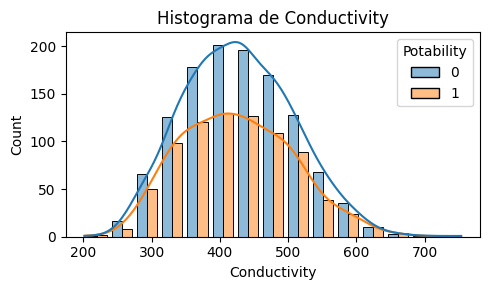

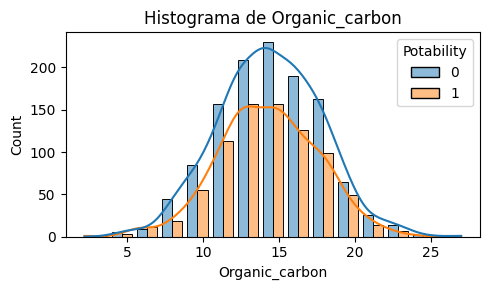

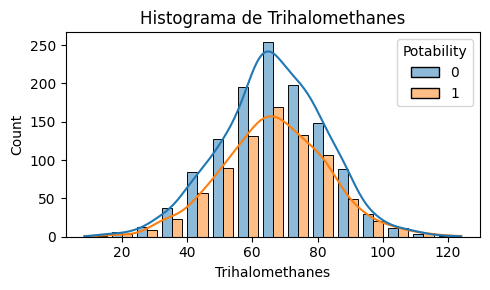

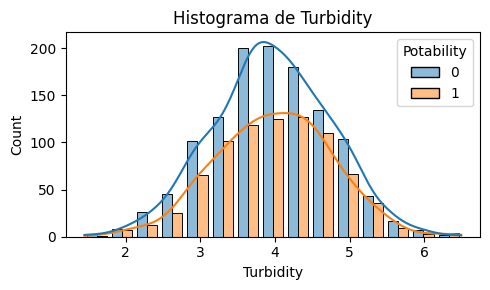

In [188]:
variables = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes',
             'Turbidity',]

for i, var in enumerate(variables):
    fig, ax = plt.subplots(figsize=(5, 3))
    sns.histplot(data=df, x=var, bins=15, hue='Potability', multiple='dodge', shrink=0.8, kde=True, ax=ax)
    ax.set_title(f"Histograma de {var}")
    plt.tight_layout()
    plt.show()

# Gráficos de disperção

Abaixo foram gerados os gráficos de disperção para ter-se uma melhor análise dos dados e assim melhorar a seleção inicial para o knn

#Gráfico de dispersão sem KDE

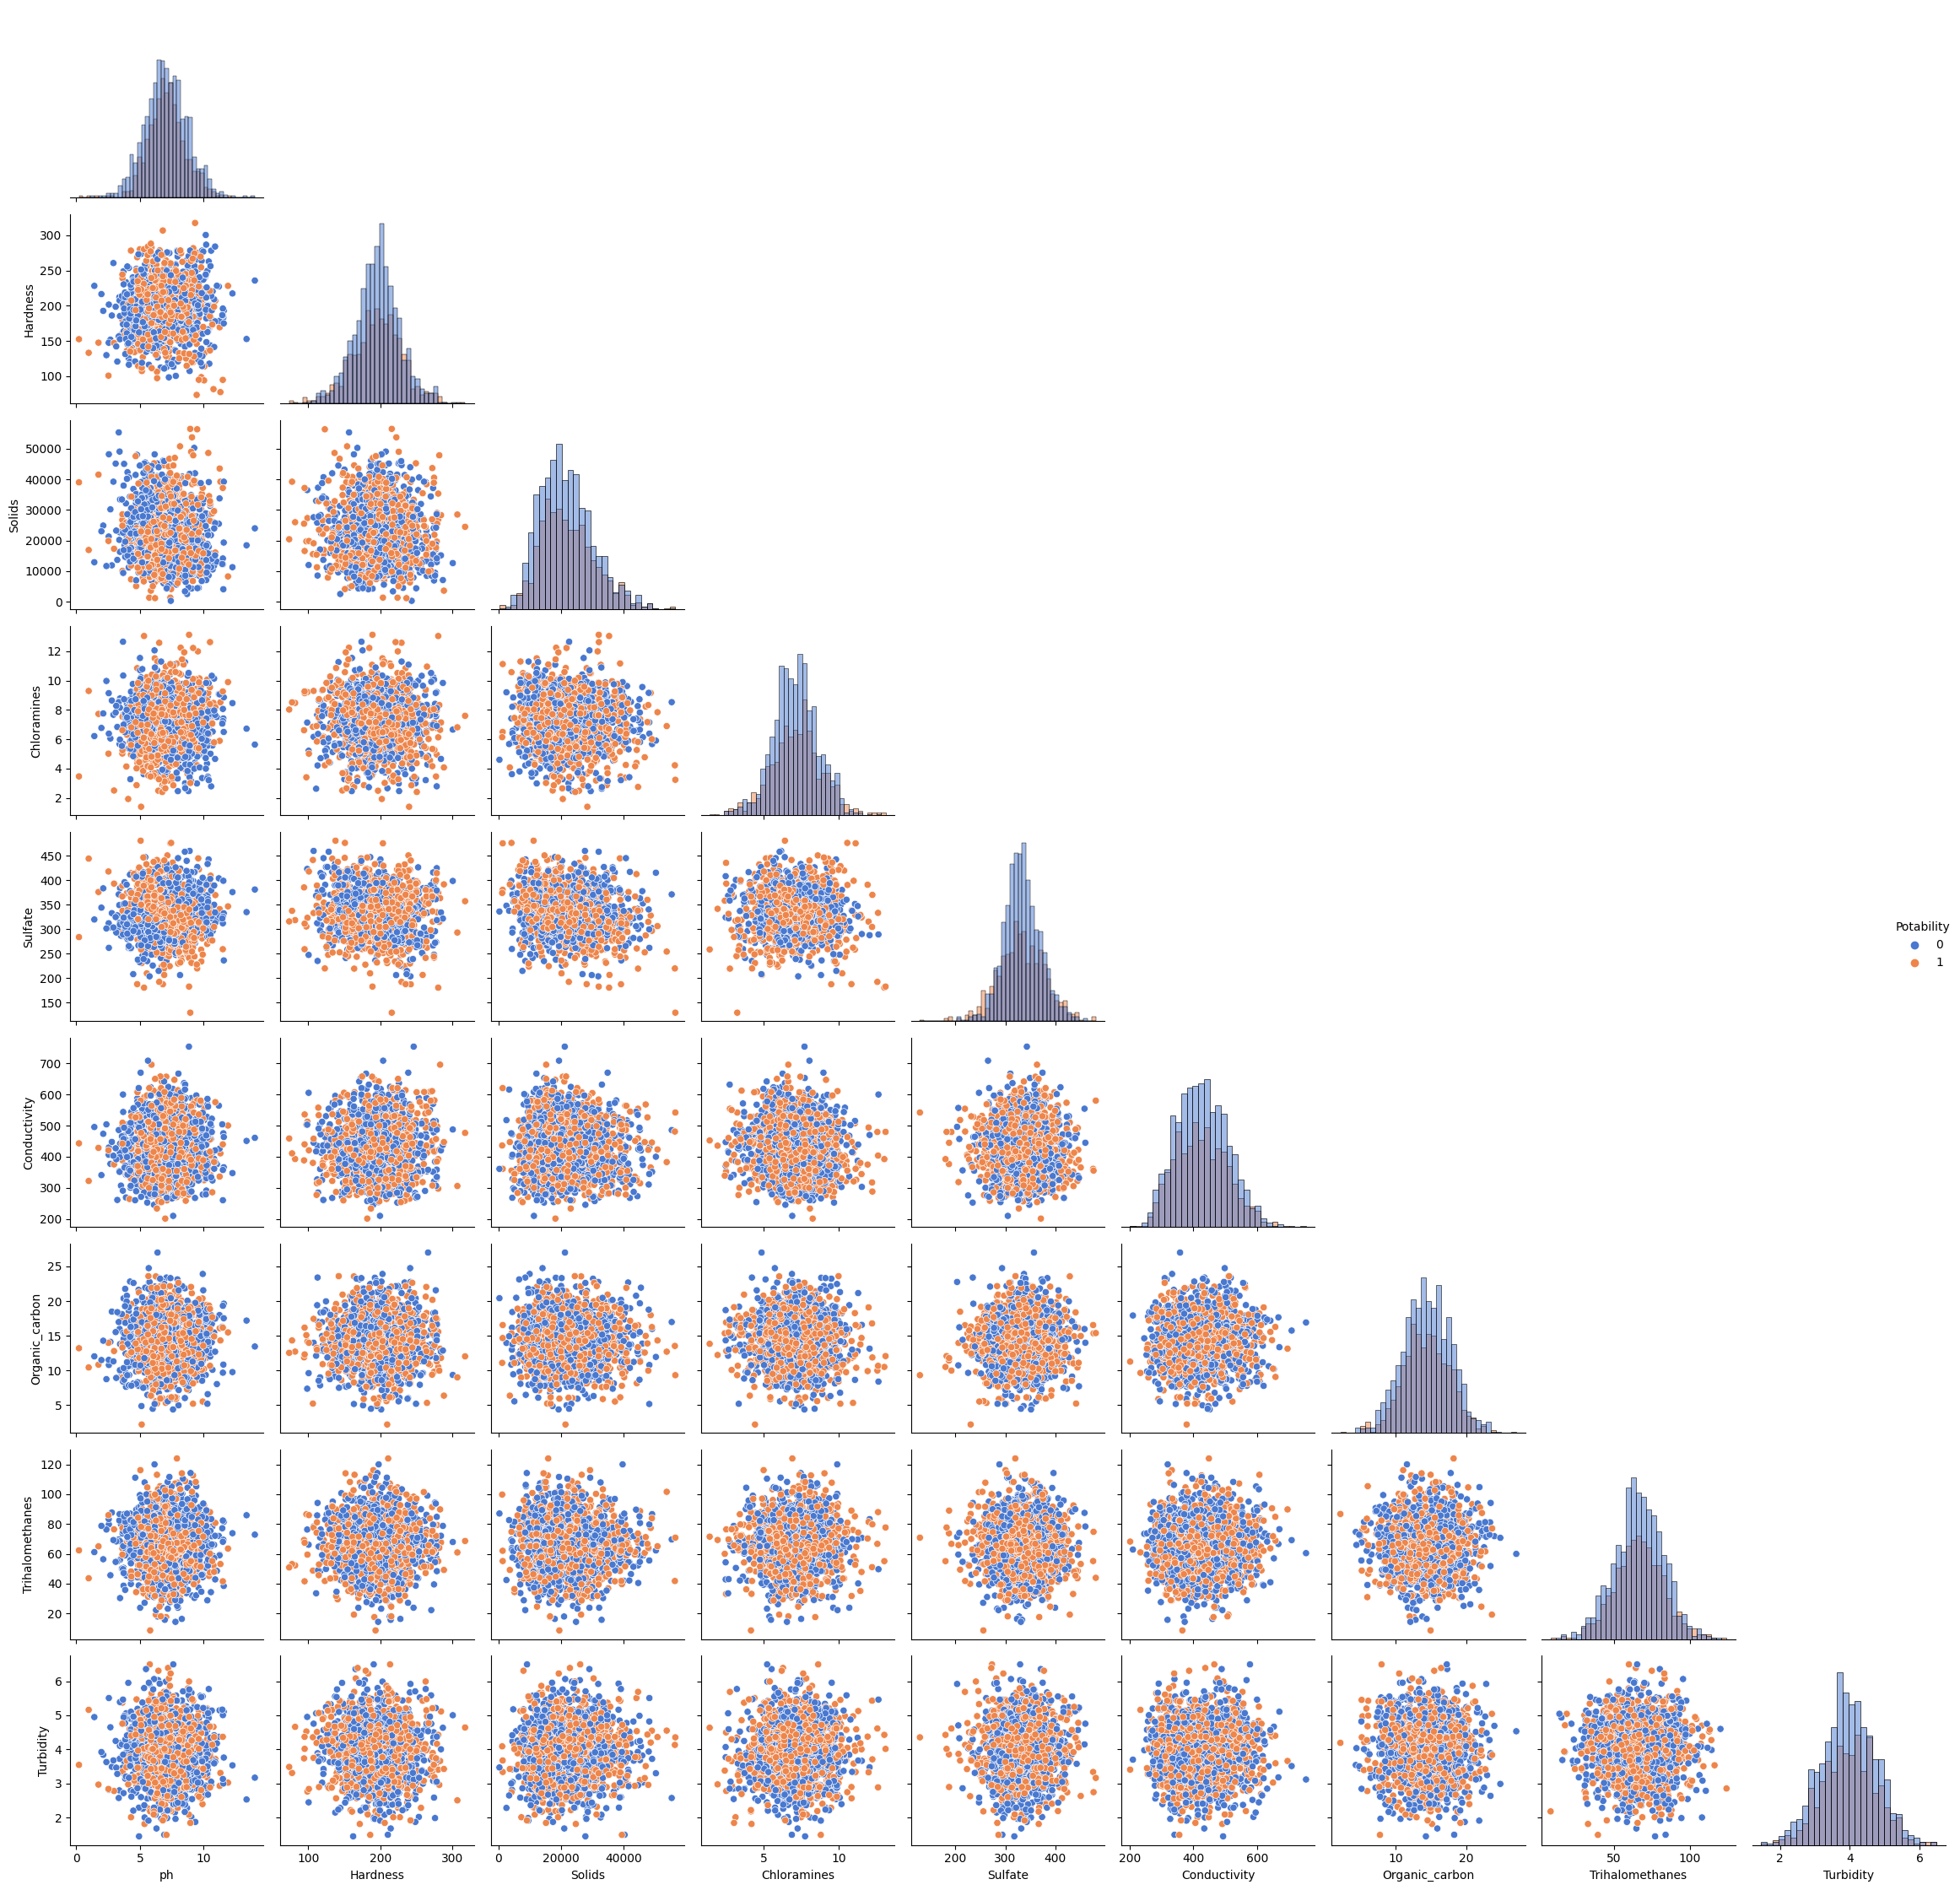

In [ ]:
sns.pairplot(df, hue='Potability', corner=True, diag_kind='hist', palette='muted')
plt.tight_layout()
plt.show()

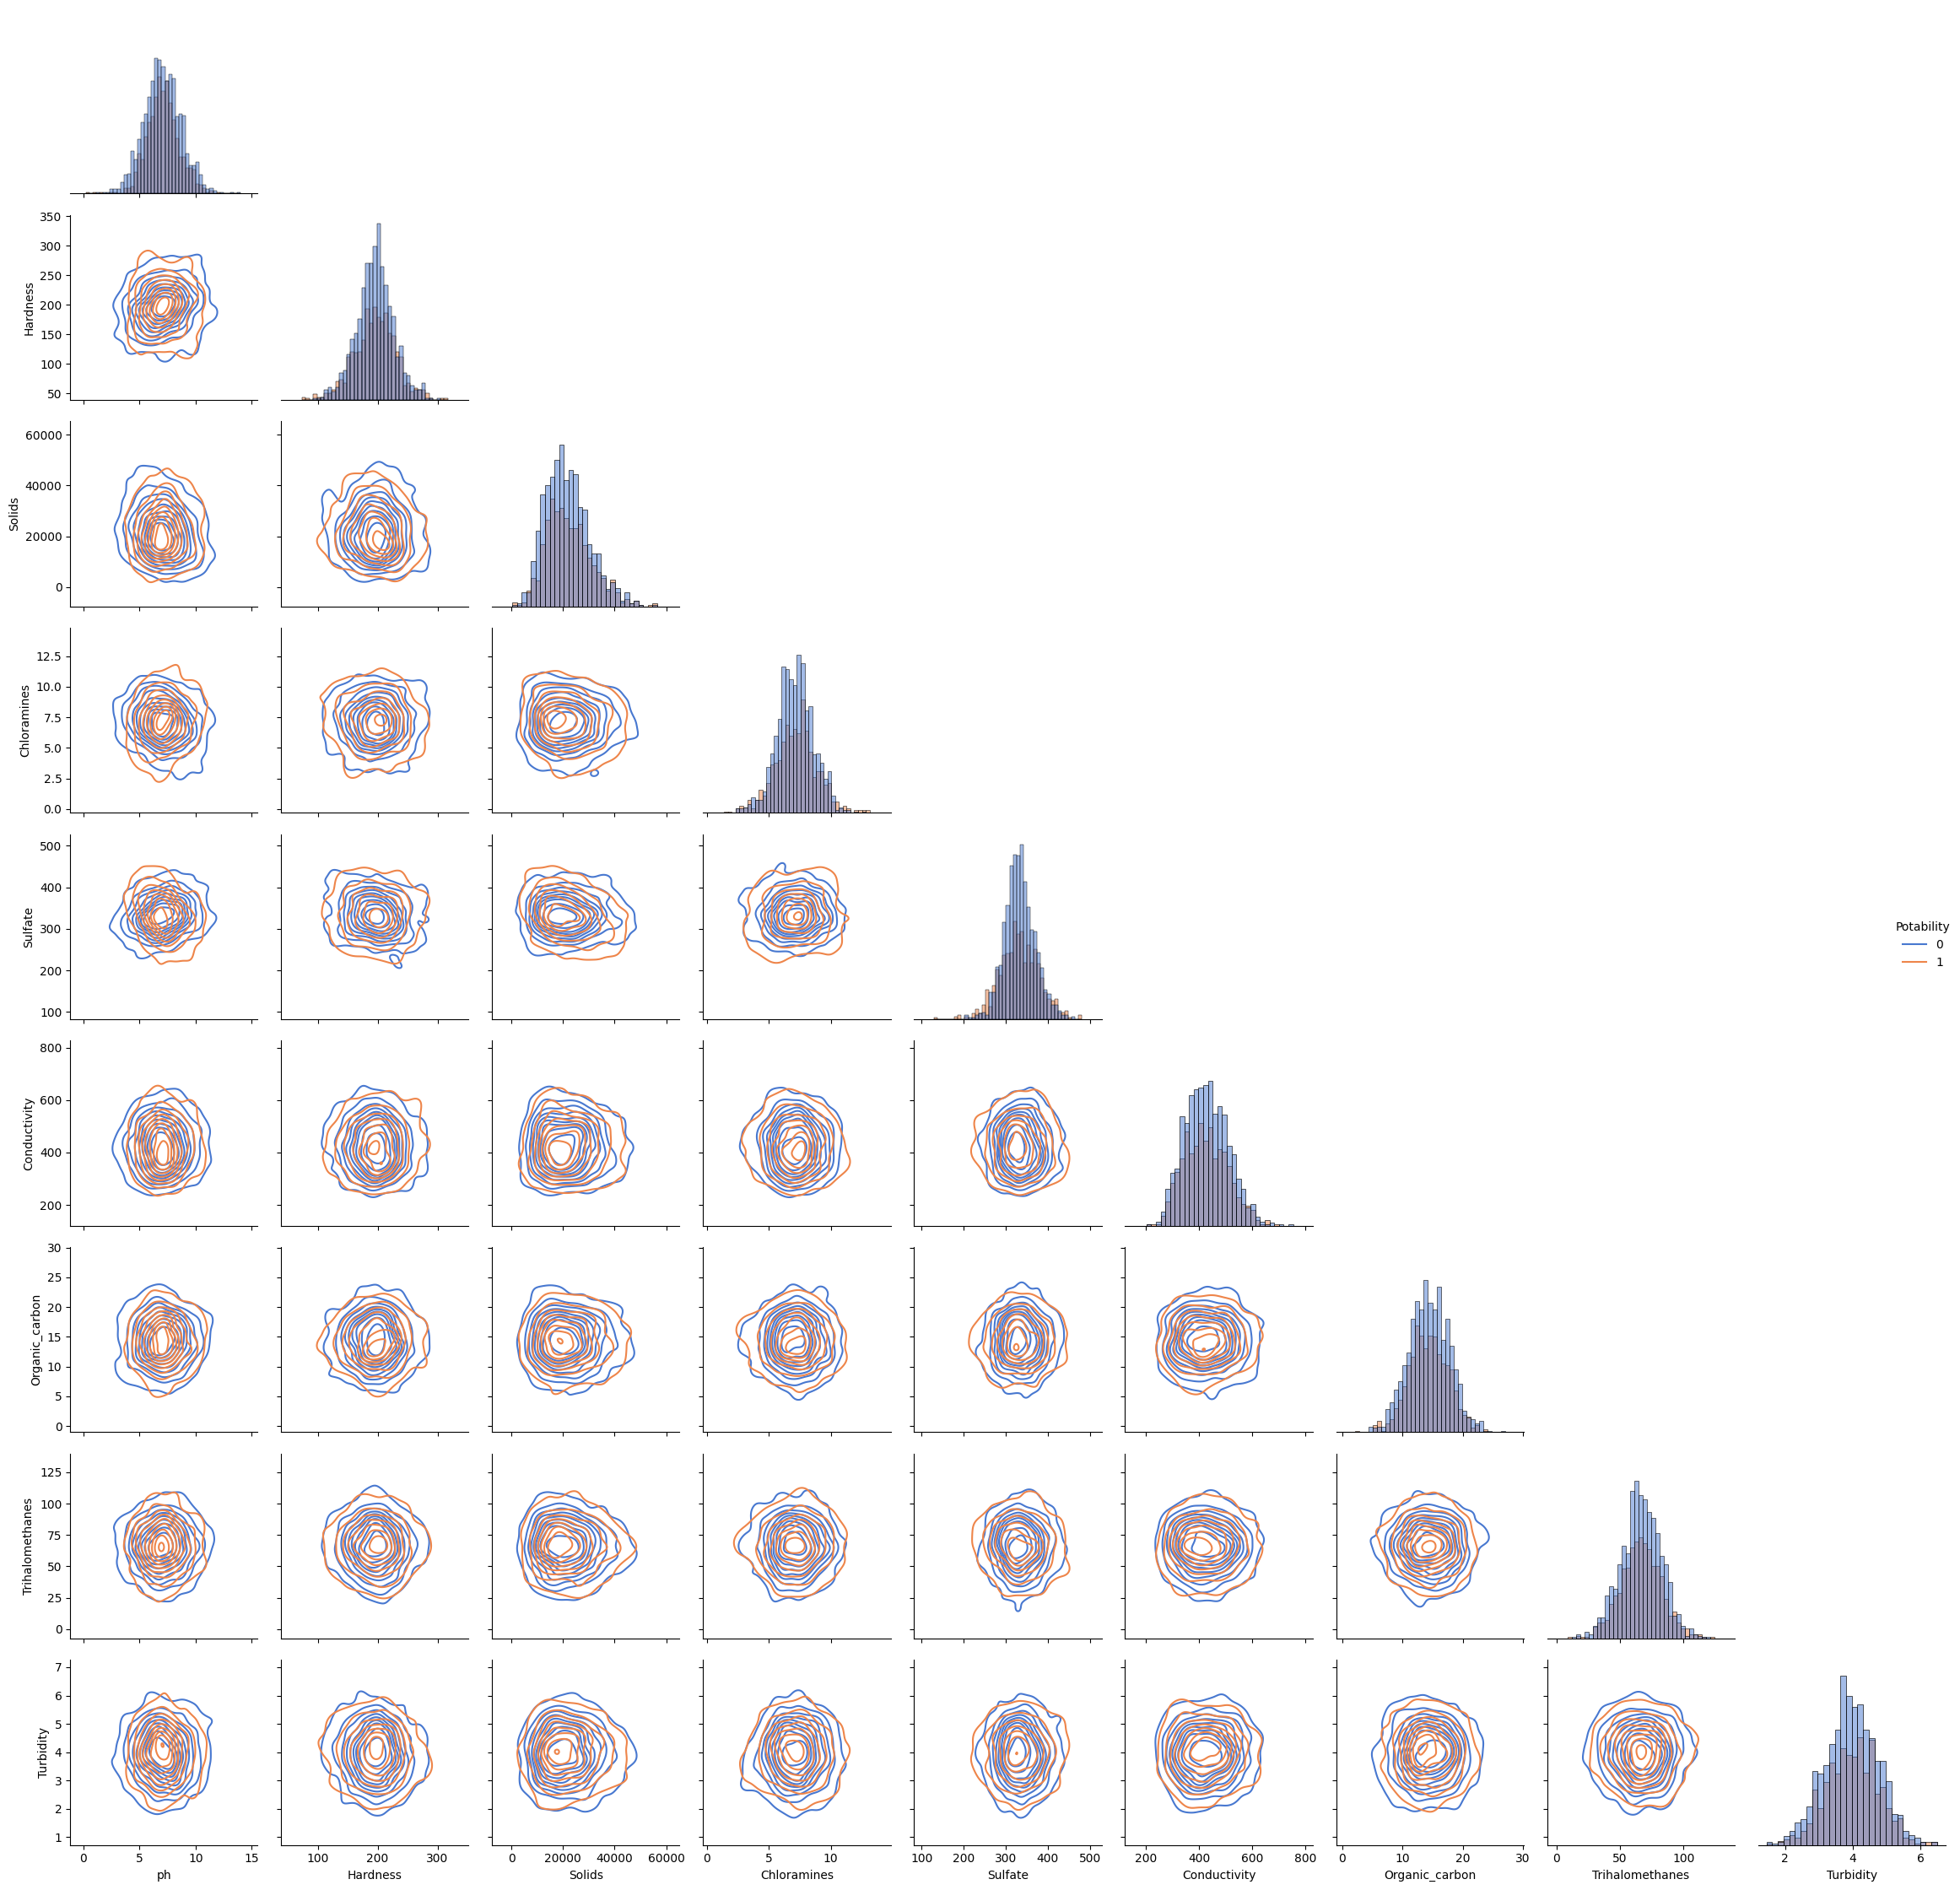

In [ ]:
sns.pairplot(df, hue='Potability', corner=True, diag_kind='hist', palette='muted',kind = 'kde')
plt.tight_layout()
plt.show()

#Como foi feita a seleção com base nos gráficos

A seleção foi escolhida tomando em conta ambos os gráficos, no KDE fica melhor a visualização. Quanto maior a convergência, menos confiáveis os dados, portanto selecionarei os cinco atributos pares mais promissores para análise

1. Sulfates e Solids;
1. Ph e Sulfates;
1. Chloramines e Hardness;
1. Sulfates e Chloramines;
1. Organic carbon e Hardness.

# Calculando as estatísticas descritivas

Após selecionados os atributos mais suspeitos, foi será calculada a estatística descritiva dos mesmos, a fim de gerar uma melhor análise

In [ ]:
df_promising = df[['Sulfate', 'ph', 'Chloramines', 'Hardness', 'Organic_carbon']]

In [ ]:
df.groupby(["Potability"]).describe()[['ph','Sulfate','Chloramines', 'Hardness', 'Organic_carbon']]

ph                                                    \
             count      mean       std       min       25%       50%   
Potability                                                             
0           1200.0  7.067201  1.659106  1.431782  5.982888  6.992004   
1            811.0  7.113791  1.437623  0.227499  6.256039  7.046549   

                                Sulfate              ...    Hardness  \
                 75%        max   count        mean  ...         75%   
Potability                                           ...               
0           8.141979  14.000000  1200.0  333.742928  ...  214.532109   
1           7.955161  11.898078   811.0  332.457832  ...  218.414531   

                       Organic_carbon                                 \
                   max          count       mean       std       min   
Potability                                                             
0           300.292476         1200.0  14.400250  3.370196  4.371899   
1           317.338124          811.0  14.294764  3.257917  2.200000   

                                                        
                  25%        50%        75%        max  
Potability                                              
0           12.118659  14.351828  16.787531  27.006707  
1           12.148355  14.252684  16.561121  23.604298  

[2 rows x 40 columns]

# Subdividindo os dados 

Depois de lido o *dataframe*, precisamos subdividir os dados em conjunto de treino e conjunto de teste, para isso, utilizaremos o *train_test_split* note que inicialmente foi feita a subdivisão com base no *Sulfate* e *Solids*, após isso, será necessário testar com os outros quatro dados escolhidos e então selecionar aquele que melhor se saiu

In [ ]:
X = df[['Sulfate' , 'Solids']]
y = df["Potability"]
df = df.reset_index(drop=True)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizando os dados

Para utilizarmos o Knn com validação cruzada, é conveniente normalizar os dados, para isso utilizaremos a função Standard Scaler do sklearn

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_treino_std = pd.DataFrame(scaler.fit_transform(X_treino), columns=X_treino.columns)
X_teste_std = pd.DataFrame(scaler.transform(X_teste), columns=X_teste.columns)

#Declarando a função Knn e utilizando-a com os dados 
## Note que o K utilizado é 10

In [ ]:
class KNN(object):
    def __init__(self, k):
        self.k = k
        self.pontos = None
        self.rotulos = None
        
    def fit(self, X, y):
        self.pontos = X
        self.rotulos = y
        
    @staticmethod
    def dist(p,q):
        return np.sqrt(np.sum((p-q)**2))    
    
    def predict(self, X):
        predicoes = []
        
        for p in X:
            d = [self.dist(p,q) for q in self.pontos]
            ds = np.argsort(d)
            knn = ds[:self.k]
            rotulos = self.rotulos[knn]
            rotulos, cont = np.unique(rotulos, return_counts=True)
            pred = rotulos[np.argmax(cont)]
            predicoes.append(pred)
        return np.array(predicoes)

knn = KNN(k=10)
knn.fit(X_treino_std.values, y_treino.values)

y_pred = knn.predict(X_teste_std.values)

acuracia = accuracy_score(y_teste, y_pred)
print(f"acuracia: {acuracia}")


acuracia: 0.5880893300248139


Acurácia de 0.58

# Utilizando PH e Sulfates

In [180]:
X = df[['ph' , 'Sulfate']]
y = df["Potability"]
df = df.reset_index(drop=True)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_treino_std = pd.DataFrame(scaler.fit_transform(X_treino), columns=X_treino.columns)
X_teste_std = pd.DataFrame(scaler.transform(X_teste), columns=X_teste.columns)

In [166]:
knn = KNN(k=10)
knn.fit(X_treino_std.values, y_treino.values)

y_pred = knn.predict(X_teste_std.values)

acuracia = accuracy_score(y_teste, y_pred)
print(f"acuracia: {acuracia}")


acuracia: 0.6352357320099256


Acurácia de 0.63

#Usando Chloramines e Hardness

In [ ]:
X = df[['Chloramines', 'Hardness']]
y = df["Potability"]
df = df.reset_index(drop=True)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_treino_std = pd.DataFrame(scaler.fit_transform(X_treino), columns=X_treino.columns)
X_teste_std = pd.DataFrame(scaler.transform(X_teste), columns=X_teste.columns)

y_pred = knn.predict(X_teste_std.values)

acuracia = accuracy_score(y_teste, y_pred)
print(f"acuracia: {acuracia}")


acuracia: 0.5409429280397022


Acurácia de 0.54

# Sulfates e Chloramines

In [ ]:
X = df[['Sulfate', 'Chloramines']]
y = df["Potability"]
df = df.reset_index(drop=True)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_treino_std = pd.DataFrame(scaler.fit_transform(X_treino), columns=X_treino.columns)
X_teste_std = pd.DataFrame(scaler.transform(X_teste), columns=X_teste.columns)

y_pred = knn.predict(X_teste_std.values)

acuracia = accuracy_score(y_teste, y_pred)
print(f"acuracia: {acuracia}")

acuracia: 0.5359801488833746


Acuracia de 0.53

In [ ]:
X = df[['Organic_carbon','Hardness']]
y = df["Potability"]
df = df.reset_index(drop=True)
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_treino_std = pd.DataFrame(scaler.fit_transform(X_treino), columns=X_treino.columns)
X_teste_std = pd.DataFrame(scaler.transform(X_teste), columns=X_teste.columns)

y_pred = knn.predict(X_teste_std.values)

acuracia = accuracy_score(y_teste, y_pred)
print(f"acuracia: {acuracia}")

acuracia: 0.5186104218362283


acuracia de 0.51

#Testando Ks para verificar qual o melhor k para validação

In [185]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Melhor k no teste: 48 (acc=0.67)


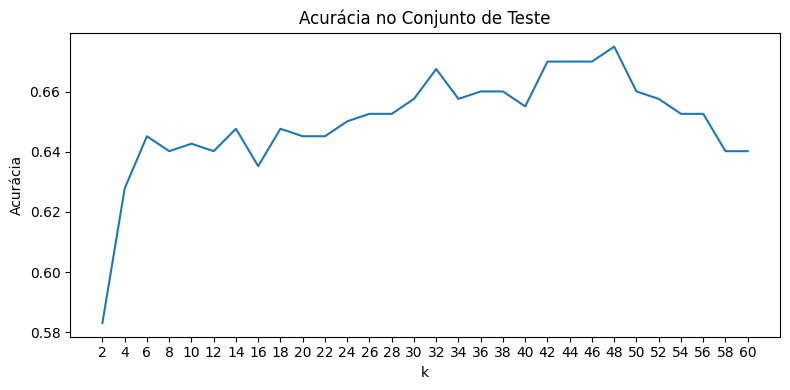

In [186]:
acuracias = []
#Vamos testar os ks pares de 1 a 60
ks = list(range(2,61,2))

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_treino, y_treino)
    pred = knn.predict(X_teste)
    
    acuracias.append(accuracy_score(y_teste, pred))

def plot_knn_k_acc(ks, acuracias, label=''):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(ks, acuracias)
    ax.set_xticks(ks)
    ax.set_xlabel('k')
    ax.set_ylabel('Acurácia')
    ax.set_title('Acurácia no Conjunto de %s' % (label))
    fig.tight_layout()
    plt.show()

melhor_teste = max(acuracias)
melhor_k_teste = ks[np.argmax(acuracias)]
print("Melhor k no teste: %d (acc=%.2f)" % (melhor_k_teste, melhor_teste))

plot_knn_k_acc(ks, acuracias, 'Teste')


Nota-se que a melhor acuracia foi obtida quando K = 49 com 68% de acurácia.

#Aplicando as distribuições de dados necessárias para otimizar os hiper parâmetros

Para aplicarmos a otimização, precisamos separar nossos dados em conjuntos de validação da mesma forma que o train test split, porém adicionaremos duas novas variáveis X_val e Y_val. 

In [187]:
X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.2, stratify=y_treino, random_state=1)

ss = StandardScaler()
ss.fit(X_treino)
X_treino = ss.transform(X_treino)
X_teste = ss.transform(X_teste)
X_val = ss.transform(X_val)

#Conclusão

Pode-se notar que a acurácia de quando foram utilizados os atributos de PH e sulfatos foi a mais alta, mesmo que em geral seu resultado tenha sido abaixo dos 70% (69%). Para melhorar, precisaríamos primeiro otimizar os hiper parâmetros e depois utilizar da validação cruzada, para assim obter um resultado satisfatório.